In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

RANDOM_SEED = 0xdeadbeef

# Neural Networks: Part 1

In this lab we will look at the following:

1. Architecture of a neural network with one hidden layer
2. Computing the forward pass by hand
3. Implementing it using numpy only
    - Implement Forward Pass
    - Computing the gradients using Stochastic Gradient Descent
    - Updating the weights
4. Implement the neural network using Keras

## Task 1: Neural Networks Forward Pass by Hand (2 Points)

In this task we use a simple neural network with one hidden layer, and show how to implement it from scratch.

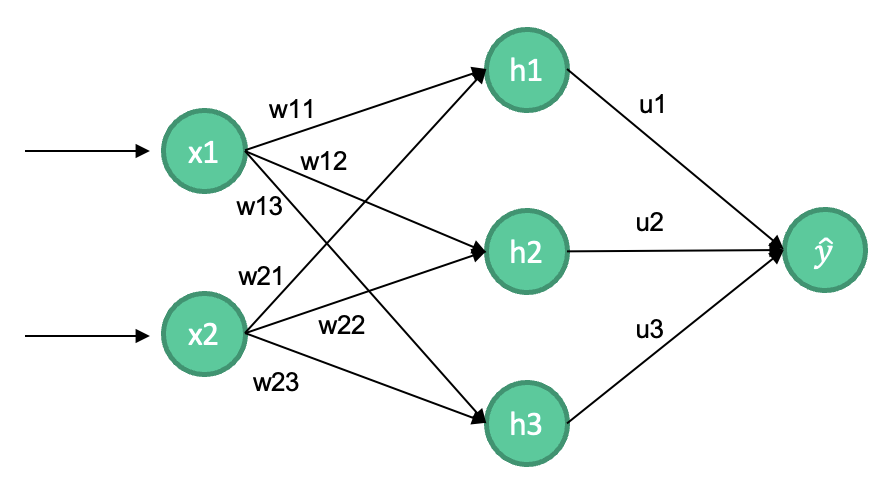![Alt text](L09_1-1_v1.dio.svg)


In the figure above, you see the diagram of a feed-forward neural network.

- 2 input nodes:        $x_1$ and $x_2$
- 3 hidden nodes:       $h_1$, $h_2$ and $h_3$
- 1 output node:        $\hat{y}$

Here are some details on the variables:

|Variable|Name|Dimensions|Notes|
|-|-|-|-|
|$X$|Input matrix|($m$,2)|Input to the neural network. Each row corresponds to a sample in the training set ($m$ is the sample size or the batch size).|
|$x$|Input |(2,1)|Single input. We have two features each in one row.|
|$W$|Weights from input to hidden layer|(2,3)|The number of columns equals the number of nodes in the hidden layer. The number of rows equals to the number of attributes for the observation in our training set.|
|$h_1, h_2, h_3$|Output of the hidden layer|($m$,3)|The number of columns equals the number of nodes in the hidden layer. The number of rows equals to the number of samples in the training set.|
|$u$|Weights from hidden to output layer|(3,1)|The number of rows match the number of nodes in the hidden layer.|
|$\hat{y}$|Model Output|(m,1)|The number of rows match the number of samples in the training set (batch).|


Each edge has a weight which is multiplied with the output of the node on the left and sent as input to the node on the right.

The $\sigma$ denotes activation function which is applied in the nodes of the hidden layer and the output layer.

> *__Note__: We do not use biases for the nodes to keep calculations simple.*


We write $NN(x, W, u)$ to denote the function computed by the above neural network.

<hr />

### Compute a single output

The full formula to compute a single output for this network is:

\begin{align}
  \hat{y} &= NN(x, W, u) \\
  &= \sigma(u_1\sigma(w_{11}x_1 + w_{21}x_2) + u_2\sigma(w_{12}x_1 + w_{22}x_2) + u_3\sigma(w_{13}x_1 + w_{23}x_2)) \\
  &= \sigma(\sum_{i = 1}^{3} u_i\sigma(w_{1i}x_1 + w_{2i}x_2))
\end{align}

Instead of this iterative way we can compute this much more efficently in python using matrix multiplication.


<hr />

## Task 1a. (2 Points)

**Given:**

The $NN(x,W,u)$ from above consiting of two input nodes, one hidden layer with three nodes and a single output node.

Assume all weights are equal to 1: $w_{ji}=1$ and $u_i=1$.

**Activation Function:**

We will use the **relu** activation function:

\begin{equation*}
  \sigma(x) = relu(x) =
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation*}

**Compute the output fo the larger network by hand**:

Compute the output $NN(x, W, u)$ for:

* $x_1=1$ and $x_2=1$
* $x_1 = 1$ and $x_2=-1$

## 📢 **HAND-IN** 📢: in Moodle

* Task a1: Output of the network for $x_1=1$ and $x_2=1$
* Task a2: Output of the network for $x_1=1$ and $x_2=-1$

<hr />

## Task 2: A simple numpy-only implementation of a neural network (5 Points)

In this task we will implement the above network $NN(x, W, u)$ in numpy and apply it to address the XOR-problem.

In the next cell, we set up the simplest instance of the XOR-problem with 4 data points.

**Observe that the classes in this problem are not linearly separable, i.e. there is no straight line that can separate the two classes.**

In [ ]:
X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1],
])

y = np.array([1, 0, 0, 1])

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap="coolwarm")

In the next cell, we randomly initialise set the initial weights of our network $W$ and $u$.
They will then updated during training via gradient descent.

In [ ]:
rng = np.random.default_rng(RANDOM_SEED)

def initialize_weights():
    """
    Randomly initialize the weight matrices W, u

    Returns:
      W: matrix with shape (2,3) and values in range [-1, 1]
      u: vector with shape (3,1) and values in range [-1, 1]
    """

    W = 2.*rng.random((2, 3)) - 1.
    u = 2 * rng.random(3) - 1.

    return W, u

W, u = initialize_weights()

print('W =', W)
print('u =', u)

### Activation function

We will use the **relu** activation as the activation function for the network:

\begin{equation}
  relu(x) =
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}



In [ ]:
def activation(x: np.array) -> np.array:
  """
  Compute relu activation for a given input

  x: a numpy array of any shape (containing floats)
  """
  return np.maximum(0., x)

The derivative of the *relu* function is undefined at $x = 0$.Therefore we set it to $0$ at that point and define it as:

\begin{equation}
  \frac{\mathrm{d}}{\mathrm{d}x}relu(x) =
  \begin{cases}
    1 & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}

In [ ]:
def derivative_activation(x: np.array) -> np.array:
  """
  Compute the derivative of relu activation for a given input.

  x: a numpy array of any shape (containing floats)
  """
  # the comparison here results in an array of booleans, which we cast to float
  return (x > 0.).astype(float)

<hr />

### Task 2a. Implement the forward pass

You can now compute the output of the neural network
for a given input $(x_1, x_2)$.

We call this computation the *forward pass* of the network, because we pass values through the network layer by layer from input to output.

The equation below, provides you the function computed by the network for a single input $x$.

\begin{align}
  NN(x, W, u) &= \sigma(u_1\sigma(w_{11}x_1 + w_{21}x_2) + u_2\sigma(w_{12}x_1 + w_{22}x_2) + u_3\sigma(w_{13}x_1 + w_{23}x_2)) \\
  &= \sigma(\sum_{i = 1}^{3} u_i\sigma(w_{1i}x_1 + w_{2i}x_2))
\end{align}

**Make sure to make the implementation as efficiently as possible using matrix/vector multiplications!**

In [ ]:
def forward_pass(
  x: np.array,
  W: np.array,
  u: np.array,
):
    """
    Implement the forward pass for our network NN(x, W, u)

    Parameters:
      x: a 2-element vector containing x_1 and x_2 (numpy array of shape (2,))
      W: a 2x3 matrix containing weights w_ji (numpy array of shape (2, 3))
      u: a 3-element vector containing u_i (numpy array of shape (3,))

    Returns:
      y: prediction of what y should be like

    In this notation the index i goes from 1 to 3 and refers to hidden nodes
    the index j goes from 1 to 2 and indexes the input dimensions

    Note: numpy array indices start from 0 not from 1
    """

    # TODO
    return ...

In the next cell, we compute the predictions of our network for our data:

In [ ]:
print("index", "x", "y", "prediction", sep="\t")
for i in range(4):
  print(i, X[i, :], y[i], forward_pass(X[i, :], W, u), sep="\t")

These are the prediction results after the first forward pass with the random initialized weights.

<hr />

### Gradient Descent

In the next cell, we implement gradient descent which we need for the cost minimization. For this purpose we need to compute all partial derivatives for the weights (model parameters) of our small network.

**In the next lab, we'll see the details on how to calculate these "Derivatives for a larger Network".** For know it is sufficient to understand that this function computes the partial derivatives needed for the gradient descent.


In [ ]:
def grads(y, x, W, u):
  """
  Compute all partial derivatives of the loss at the sample x, y
  for all weights u_i and w_ji in our network

  Parameters:
    y: float indicating the true label of the sample (either 0. or 1.)
    x: a 2-element vector containing x_1 and x_2 of our sample (numpy array of shape (2,))
    W: a 2x3 matrix containing weights w_ji (numpy array of shape (2, 3))
    u: a 3-element vector containing u_i (numpy array of shape (3,))

  Returns:
    grad_u: a 3-element vector containing partial derivatives d/du_i
    grad_w: a 2x3 matrix containing partial derivatives d/dw_ji
  """
  pred = forward_pass(x, W, u)

  # compute derivative of our squared error loss
  derivative_loss = 2*(pred - y)

  # compute derivative of the output activation
  deriv_output = derivative_activation(u @ activation(x.T @ W))

  grad_u = np.zeros_like(u)
  for i in range(3):
    # compute derivatives with respect to u_i according to the formula in Task 1
    grad_u[i] = derivative_loss * deriv_output * activation(W[:, i] @ x)

  grad_w = np.zeros_like(W)
  for i in range(3):
    for j in range(2):
      # compute derivatives with respect to w_ji according to the formula in Task 1
      grad_w[j, i] = derivative_loss * deriv_output * u[i] * derivative_activation(W[:, i] @ x) * x[j]

  return grad_u, grad_w


<hr />

### Task 2b. Training the network using Stochastic Gradient Descent

Below we give you the setup for the main learning loop.
Your task is to implement the weight updates according to stochastic gradient descent.

**For stochastic gradient descent, at each time step $t$ we sample one data point $x^{(t)}$ and its label (the desired output) $y^{(t)}$.**

We calculate the loss $L$ at time $t$:

\begin{align}
L^{(t)} = \mathcal{L}(y^{(t)}, NN(x^{(t)}, W, u))
\end{align}

Then we update our weights as follows:

\begin{align}
  u_{i}^{(t+1)} = u_{i}^{(t)} - \alpha \frac{\mathrm{d}}{\mathrm{d}u_i}L^{(t)} \\
  w_{ji}^{(t+1)} = w_{ji}^{(t)} - \alpha \frac{\mathrm{d}}{\mathrm{d}w_{ji}}L^{(t)} \\
\end{align}

where $\alpha$ denotes the learning rate.

> *__Note__: In this simple example where we try to learn a very simple xor-function we only have 4 samples. To show the learning dynamics we choose stochastic gradient descent.*

**Adjust the code by**
- Specifying a learning_rate $\alpha$
- Specifying a maximum number of update steps `n_steps`
- Implementing the weight updates for $W$ and $u$

> **Note**: Because the weights are randomly inizialized and the samples are randomly choosen you can try to run the cell multiple times for the same values of the hyperparameters (the learning rate and the number of iterations).

In [ ]:
W, u = initialize_weights()

learning_rate = ...   # choose a learning rate
n_steps = ...         # choose a number of training iterations

losses = []

for t in range(n_steps):

  # randomly sample one of the 4 data points
  sample_ix = rng.integers(0,4)
  x_t = X[sample_ix]
  y_t = y[sample_ix]

  # compute and log squared error for the current sample
  loss = 0.5 * (y_t - forward_pass(x_t, W, u))**2
  losses.append(loss)

  # compute gradients (partial derivatives of our weights)
  grad_u, grad_w = grads(y_t, x_t, W, u)

  # update the weights (model parameters)
  W = ...
  u = ...

# plot learning curve
plt.plot(np.arange(n_steps), losses)

In the next cell, we compute the predictions of our network on our data after training the model:

In [ ]:
print("index", "x", "y", "prediction", sep="\t")
for i in range(4):
  print(i, X[i, :], y[i], forward_pass(X[i, :], W, u), sep="\t")

## 📢 **HAND-IN** 📢: in Moodle

* Your implementation of `forward_pass`
* The weight updates
* Plot of your learning curve

<hr />

## Task 3: Neural Networks in Keras (3 Points)

We will now implement the network from above in [Keras](https://keras.io/).

It is a relatively simple and user friendly library to implement neural networks.

In [ ]:
!pip install keras tensorflow

In [ ]:
from sklearn.datasets import make_blobs

X, y = make_blobs(
  n_samples=1000,
  n_features=2,
  centers=np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
  ]),
  cluster_std=.25,
  shuffle=True,
  random_state=RANDOM_SEED,
)
y[y == 2] = 1
y[y == 3] = 0

plt.scatter(X[:, 0],X[:, 1],c=y,s=20,cmap="bwr")

In [ ]:
from keras import Sequential
from keras.layers import Activation, Dense

Below we implement the exact same neural network that we have been working with so far.

First we define an empty `Sequential` model. This is the most common type of model, where values are passed from layer to layer sequentially.

We then add various layers to our model. We use two types of layers: `Dense` and `Activation`.

The `Dense` layer implements the weighted sum and the `Activation` layer implements the activation function.

A `Dense` layer implements a simple linear transform (matrix multiplication + bias). For a given input $x$ it computes: $Wx + b$. The matrix $W$ contains the weights of the layer and $b$ is the bias term. Note that in our original network we did not use any biases, so we set `use_bias=False` below. The first argument to the `Dense` class defines the number of outputs of the layer. The argument `input_shape` defines the number of inputs.

An `Activation` layer implements the various activation functions. We use *relu* activations, as in our hand-made network above. Activation functions are applied **separately** to each node and we therefore do not have to define input and output dimensions.

Check the [Keras Documentation](https://keras.io/guides/sequential_model/) for further details.

> **Note:** that in our original network we did not use any biases, so we set `use_bias=False` below.


In [ ]:
model = Sequential()
model.add(Dense(3, input_shape=(2,), use_bias=False))
model.add(Activation("relu"))
model.add(Dense(1, input_shape=(3,), use_bias=False))
model.add(Activation("relu"))

**Before you continue**, compute the number of model parameters of this neural network.

The method `model.summary()` gives an overview of the different layers in our models, showing in particular the number of trainable parameters in our network.

In [ ]:
model.summary()

In the next cell, we prepare the model for training using the `.compile` method.

To stay consistent with the step-by-step implementation from the previous task, we choose `optimizer="sgd"` for "stochastic gradient descent".

We choose `loss="mse"` (even though for classification, `loss="binary_crossentropy"` would be more appropriate, but again we want to stay close to the manual example above).

By default, keras will log the loss during training.
We can additionally ask it to compute and log additional metrics.
Below, we pass `metrics=['accuracy']` to also log accuracy while training.

> *__Note__: `accuracy` and `loss` will be computed and logged on the __training data__*

In [ ]:
model.compile(optimizer="sgd", loss="mse", metrics=['accuracy'])

In [ ]:
history = model.fit(X, y, epochs=10, batch_size=1)

We can use the History object to plot the learning curve and accuracy over time (where time is measured in epochs, meaning number of passes over the full data set).

In [ ]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['accuracy'], label="Accuracy")
plt.grid()
plt.legend()

In the next cell we will plot decision boundaries to better understand what the model has learned.


In [ ]:
def plot_model_out(x_space,y_space,model):
  """
  Parameters:
    x_space,y_space: 2D MeshGrid input
    model: Keras Model API Object
  """
  grid = np.stack((x_space,y_space))
  grid = grid.T.reshape(-1,2)
  outs = model.predict(grid)
  y1 = outs.T[0].reshape(x_space.shape[0],x_space.shape[0])
  plt.contourf(x_space,y_space,y1,alpha=.6,cmap="coolwarm")

In [ ]:
a = np.linspace(-2, 2, 100)
x_space, y_space = np.meshgrid(a,a)
plot_model_out(x_space,y_space,model)
plt.scatter(X[:, 0], X[:, 1],c=y,s=20,cmap="bwr")
plt.colorbar()

### Task 3a.

What could we change so that we obtain better quality predictions?

Change one of these options at a time and try to understand what their influence on the result is?

**Model Options:**

- Increase the number of hidden nodes
- Increase the number of layers
- Change to `use_bias=True`
- Change the `Activation` function

**Compile Options:**

- Change the `optimizer` (Check the available options in the [Keras Documentation](https://keras.io/api/optimizers/#available-optimizers))
- Change the `loss` to `binary_crossentropy`


**Fit Options:**

- Change the number of `epochs`
- Change the `batch_size`


**Which option has the biggest impact on the performance of the model?**


## 📢 **HAND-IN** 📢: in Moodle

* the option that worked best for you
* the final accuracy you achieved using it